In [2]:
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, save, load
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [13]:
pwd = %pwd
proc_fn = lambda x: transforms.Normalize([0.5], [0.5])(transforms.ToTensor()(x.convert('L')))
data = SVHN(
    pwd, 
    download=True, 
    transform=proc_fn,
)
np.place(data.labels, data.labels == 10, 0)

Using downloaded and verified file: /Users/jtao/Documents/coco/clock_algo/train_32x32.mat


In [14]:
pwd = %pwd
test = SVHN(
    pwd, 
    split='test',
    download=True, 
    transform=proc_fn,
)
np.place(test.labels, test.labels == 10, 0)

Using downloaded and verified file: /Users/jtao/Documents/coco/clock_algo/test_32x32.mat


In [5]:
train_loader = DataLoader(dataset=data,
                               batch_size=100,# 这里定义了batch_size
                               shuffle=True,
                               num_workers=2)
test_loader = DataLoader(dataset=test,
                               batch_size=100,# 这里定义了batch_size
                               shuffle=True,
                               num_workers=2)

In [103]:
# 迭代开始，然后，队列和线程跟着也开始
data_iter = iter(train_loader)

# mini-batch 图像 和 标签
images, labels = next(data_iter)

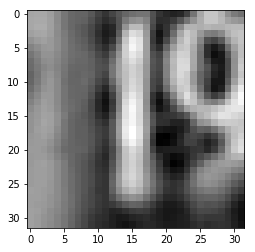

In [15]:
plt.imshow(images[6].numpy()[0], cmap='gray')

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):#需要继承这个类
    def __init__(self):
        super(Net, self).__init__()
        #建立了两个卷积层，self.conv1, self.conv2，注意，这些层都是不包含激活函数的
        self.conv1 = nn.Conv2d(1, 6, 3) # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv2 = nn.Conv2d(6, 16, 3)
        #三个全连接层
        self.fc1   = nn.Linear(16*6*6, 128) # an affine operation: y = Wx + b
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 10)

    def forward(self, x): #注意，2D卷积层的输入data维数是 batchsize*channel*height*width
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # If the size is a square you can only specify a single number
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
def error_rate(loader, model, sample_rate=0.1):
    err = []
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx > len(loader) * sample_rate: break
        output = net(Variable(images))
        output = np.argmax(output.data.numpy(), axis=1)
        err.append(np.sum(output != labels.squeeze().numpy()) * 1.0 / len(output))
    return np.mean(err)

        
net = Net()
# data_iter = iter(train_loader)

# mini-batch 图像 和 标签
# images, labels = next(data_iter)

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr = 0.01)
num_epoch = 1000

test_acc_arr = []

# in your training loop:
for i in range(num_epoch):
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad() # zero the gradient buffers，如果不归0的话，gradients会累加

        output = net(Variable(images)) # 这里就体现出来动态建图了，你还可以传入其他的参数来改变网络的结构\
        target = Variable(labels).squeeze().long()

        loss = F.nll_loss(output, target)
        loss.backward() # 得到grad，i.e.给Variable.grad赋值
        optimizer.step() # Does the update，i.e. Variable.data -= learning_rate*Variable.grad

        if not batch_idx % 300:
            print('Epoch {} batch {}: loss {}'.format(i, batch_idx, loss))
            print('Training acc: {}'.format(1.0 - error_rate(train_loader, net)))
    test_acc = 1.0 - error_rate(test_loader, net)
    print('Test acc: {}'.format(test_acc))
    test_acc_arr.append(test_acc)
    if test_acc > 0.6:
        save(net, 'vanilla_model_epoch_{}.pkl'.format(i))
        if len(test_acc_arr) > 3 and test_acc_arr[-1] < test_acc_arr[-2] < test_acc_arr[-3] < test_acc_arr[-4]:
            print('Test acc going down consecutively 3 times, stop training')
            break


Epoch 0 batch 0: loss Variable containing:
 2.2920
[torch.FloatTensor of size 1]

Training acc: 0.121756756757
Epoch 0 batch 300: loss Variable containing:
 2.2578
[torch.FloatTensor of size 1]

Training acc: 0.193243243243
Epoch 0 batch 600: loss Variable containing:
 2.2290
[torch.FloatTensor of size 1]

Training acc: 0.188783783784
Test acc: 0.202222222222
Epoch 1 batch 0: loss Variable containing:
 2.2025
[torch.FloatTensor of size 1]

Training acc: 0.188243243243
Epoch 1 batch 300: loss Variable containing:
 2.2853
[torch.FloatTensor of size 1]

Training acc: 0.191621621622
Epoch 1 batch 600: loss Variable containing:
 2.2371
[torch.FloatTensor of size 1]

Training acc: 0.181621621622
Test acc: 0.195555555556
Epoch 2 batch 0: loss Variable containing:
 2.2629
[torch.FloatTensor of size 1]

Training acc: 0.185675675676
Epoch 2 batch 300: loss Variable containing:
 2.2600
[torch.FloatTensor of size 1]

Training acc: 0.189864864865
Epoch 2 batch 600: loss Variable containing:
 2.2015

/Users/jtao/miniconda2/lib/python2.7/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 11 batch 0: loss Variable containing:
 1.3807
[torch.FloatTensor of size 1]

Training acc: 0.589324324324
Epoch 11 batch 300: loss Variable containing:
 1.1019
[torch.FloatTensor of size 1]

Training acc: 0.661891891892
Epoch 11 batch 600: loss Variable containing:
 0.8875
[torch.FloatTensor of size 1]

Training acc: 0.713648648649
Test acc: 0.72962962963
Epoch 12 batch 0: loss Variable containing:
 0.8916
[torch.FloatTensor of size 1]

Training acc: 0.712702702703
Epoch 12 batch 300: loss Variable containing:
 1.0589
[torch.FloatTensor of size 1]

Training acc: 0.751756756757
Epoch 12 batch 600: loss Variable containing:
 0.8618
[torch.FloatTensor of size 1]

Training acc: 0.757162162162
Test acc: 0.772592592593
Epoch 13 batch 0: loss Variable containing:
 0.6715
[torch.FloatTensor of size 1]

Training acc: 0.774864864865
Epoch 13 batch 300: loss Variable containing:
 0.6766
[torch.FloatTensor of size 1]

Training acc: 0.779459459459
Epoch 13 batch 600: loss Variable containing:

Training acc: 0.895540540541
Epoch 33 batch 600: loss Variable containing:
 0.3779
[torch.FloatTensor of size 1]

Training acc: 0.907432432432
Test acc: 0.861851851852
Epoch 34 batch 0: loss Variable containing:
 0.5755
[torch.FloatTensor of size 1]

Training acc: 0.900135135135
Epoch 34 batch 300: loss Variable containing:
 0.4413
[torch.FloatTensor of size 1]

Training acc: 0.900405405405
Epoch 34 batch 600: loss Variable containing:
 0.3734
[torch.FloatTensor of size 1]

Training acc: 0.890540540541
Test acc: 0.858888888889
Epoch 35 batch 0: loss Variable containing:
 0.2824
[torch.FloatTensor of size 1]

Training acc: 0.907027027027
Epoch 35 batch 300: loss Variable containing:
 0.4930
[torch.FloatTensor of size 1]

Training acc: 0.894864864865
Epoch 35 batch 600: loss Variable containing:
 0.3149
[torch.FloatTensor of size 1]

Training acc: 0.90472972973
Test acc: 0.847777777778
Epoch 36 batch 0: loss Variable containing:
 0.1693
[torch.FloatTensor of size 1]

Training acc: 0.8971

Epoch 56 batch 0: loss Variable containing:
 0.2971
[torch.FloatTensor of size 1]

Training acc: 0.933513513514
Epoch 56 batch 300: loss Variable containing:
 0.1642
[torch.FloatTensor of size 1]

Training acc: 0.939594594595
Epoch 56 batch 600: loss Variable containing:
 0.3197
[torch.FloatTensor of size 1]

Training acc: 0.937837837838
Test acc: 0.871851851852
Epoch 57 batch 0: loss Variable containing:
 0.1227
[torch.FloatTensor of size 1]

Training acc: 0.938783783784
Epoch 57 batch 300: loss Variable containing:
 0.3786
[torch.FloatTensor of size 1]

Training acc: 0.934864864865
Epoch 57 batch 600: loss Variable containing:
 0.1910
[torch.FloatTensor of size 1]

Training acc: 0.928918918919
Test acc: 0.866666666667
Epoch 58 batch 0: loss Variable containing:
 0.1453
[torch.FloatTensor of size 1]

Training acc: 0.936486486486
Epoch 58 batch 300: loss Variable containing:
 0.3186
[torch.FloatTensor of size 1]

Training acc: 0.940135135135
Epoch 58 batch 600: loss Variable containing

In [72]:
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
from PIL import Image, ImageOps
def preproc_img(file_path):
    desired_sz = 32.0
    img = Image.open(file_path)
    w, h = img.size
    resize_ratio = desired_sz / max(w, h)
    img.resize((int(w*resize_ratio), int(h*resize_ratio)))
    
    #pad image to make 32x32
    w, h = img.size
    delta_w = desired_sz - w
    delta_h = desired_sz - h
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    new_im = ImageOps.expand(
        img, 
        padding
    )
    
    # gray, norm, tensor
    return proc_fn(new_im)
    
    
def predict_image(file_path_list, model):
    

In [11]:
fc = lambda x: x+1

In [16]:
max(*(1,2))

2

In [17]:
32/5

6

In [18]:
31//2

15